# Empirical analysis of the 5G coverage 

#### Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest
import scikit_posthocs as sp

#### Dataset

In [3]:
df_4g = pd.read_csv('datasets/4G-Passive-Measurements.csv')

In [4]:
print(df_4g.columns)
df = df_4g[['RSRP', 'Speed', 'distance', 'Latitude', 'Longitude', 'scenario', 'MNC']]
df = df[(df['RSRP'] >= -144) & (df['RSRP'] <= -44)]  # remove impossible values 
df = df[(df['scenario'] == 'OD') | (df['scenario'] == 'IS')]
df = df.replace('"Op"[1]', 'Op1')
df = df.replace('"Op"[2]', 'Op2')
print(df.head())

Index(['Unnamed: 0', 'Date', 'Time', 'UTC', 'Latitude', 'Longitude',
       'Altitude', 'Speed', 'EARFCN', 'Frequency', 'PCI', 'MNC',
       'CellIdentity', 'eNodeB.ID', 'Power', 'SINR', 'RSRP', 'RSRQ',
       'scenario', 'cellLongitude', 'cellLatitude', 'cellPosErrorLambda1',
       'cellPosErrorLambda2', 'n_CellIdentities', 'distance', 'Band',
       'campaign'],
      dtype='object')
        RSRP  Speed    distance   Latitude  Longitude scenario  MNC
9629  -87.19   3.60  681.668663  41.893101  12.494476       IS  Op1
9630  -93.24   3.60  154.023876  41.893101  12.494476       IS  Op1
9631  -85.16   1.26  679.486796  41.893141  12.494451       IS  Op1
9632  -89.99   1.26  156.301756  41.893141  12.494451       IS  Op1
9633 -115.25   1.26  273.746723  41.893141  12.494451       IS  Op1


In [5]:
op1_is = df[(df['scenario'] == 'IS') & (df['MNC'] == "Op1")]
op1_od = df[(df['scenario'] == 'OD') & (df['MNC'] == "Op1")]
op2_is = df[(df['scenario'] == 'IS') & (df['MNC'] == "Op2")]
op2_od = df[(df['scenario'] == 'OD') & (df['MNC'] == "Op2")]

print(op1_od.head())

         RSRP  Speed    distance   Latitude  Longitude scenario  MNC
14168  -92.64   2.59  140.986376  41.866440  12.530809       OD  Op1
14172 -108.02  22.07  168.332515  41.866187  12.530826       OD  Op1
14173  -96.76  22.07  168.332515  41.866187  12.530826       OD  Op1
14177  -96.31  32.58  218.432923  41.865719  12.530988       OD  Op1
14179 -106.81  30.46  234.582894  41.865571  12.531048       OD  Op1


### Create violin plots to inspect distributions

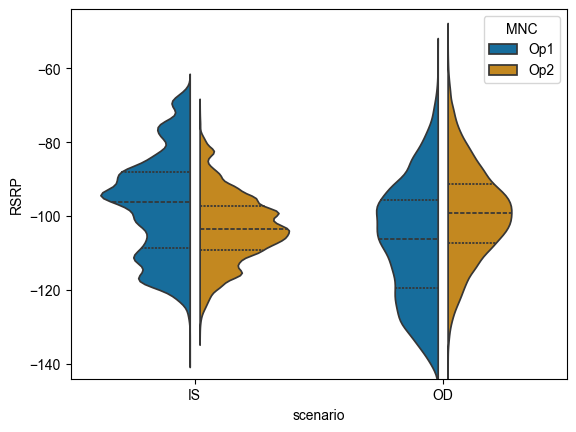

In [6]:
sns.violinplot(x='scenario', y='RSRP', hue='MNC', data=df, split=True, gap=0.1, inner='quart', palette='colorblind')
## lines show the quartiles of the data
sns.set_style('whitegrid')
plt.ylim(-144, -44)
plt.show()

In [7]:
df_4g = df_4g[(df_4g['RSRP'] >= -144) & (df_4g['RSRP'] <= -44) &
              (df_4g['RSRQ'] >= -19.5) & (df_4g['RSRQ'] <= -3) &
              (df_4g['SINR'] >= -20) & (df_4g['SINR'] <= 20)]
df_4g = df_4g.fillna(0)

### Statistical analysis

In [8]:
# test for normal distribution
_, p_op1_is = kstest(op1_is['RSRP'], 'norm')
_, p_op1_od = kstest(op1_od['RSRP'], 'norm')
_, p_op2_is = kstest(op2_is['RSRP'], 'norm')
_, p_op2_od = kstest(op2_od['RSRP'], 'norm')

print(f'Statistcal results for testing for normal distribution are:\n'
      f'Operator 1, IS: {p_op1_is:.3f}\n'
      f'Operator 1, OD: {p_op1_od:.3f}\n'
      f'Operator 2, IS: {p_op2_is:.3f}\n'
      f'Operator 2, OD: {p_op2_od:.3f}')

Statistcal results from tests are:
Operator 1, IS: 0.000
Operator 1, OD: 0.000
Operator 2, IS: 0.000
Operator 2, OD: 0.000


All test show p-values < 0.001, rejecting the null-hypothesis of a normal distribution.
Therefore, for futher statistical testing, non-parametric tests need to be used.

In [34]:
n_test = 4  # bonferroni correction on multiple comparisons
data = [op1_is['RSRP'], 
        op1_od['RSRP']]
p_op1_isvod = sp.posthoc_dunn(data) * n_test

data = [op2_is['RSRP'],
        op2_od['RSRP']]
p_op2_isvod = sp.posthoc_dunn(data) * n_test

data = [op1_is['RSRP'], 
        op2_is['RSRP']]
p_is_1v2 = sp.posthoc_dunn(data) * n_test

data = [op1_od['RSRP'],
        op2_od['RSRP']]
p_od_1v2 = sp.posthoc_dunn(data) * n_test


print(f"Statistical test results from Dunn's test while using a Bonferroni correction based on {n_test} tests:\n"
      f"Operator 1, IS vs. OD: {p_op1_isvod.iloc[0, 1]:.3f}\n"
      f"Operator 2, IS vs. OD: {p_op2_isvod.iloc[0, 1]:.3f}\n"
      f"Operator 1 vs. Operator 2, IS: {p_is_1v2.iloc[0, 1]:.3f}\n"
      f"Operator 1 vs. Operator 2, OD: {p_od_1v2.iloc[0, 1]:.3f}")

Statistical test results from Dunn's test while using a Bonferroni correction based on 4 tests:
Operator 1, IS vs. OD: 0.000
Operator 2, IS vs. OD: 0.000
Operator 1 vs. Operator 2, IS: 0.000
Operator 1 vs. Operator 2, OD: 0.000


### What can we do in the assignment?

* Could it be an idea to look at the correlation between signal strength and number of PCIs connected to the unit (4g dataset)?
* Alternatively, look into the different kinds of RSRPs in the 5g dataset and do a kind of time analysis?
* Or something completely different? I don't really know what could be possible and is easy enough to do in 1,5 weeks lol

In [10]:
def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr

print(f'Pearson correlation between RSRP and n_CellIdentities: ', Pearson_correlation(df_4g['RSRP'], df_4g['n_CellIdentities']))
print(f'Pearson correlation between SINR and n_CellIdentities: ', Pearson_correlation(df_4g['SINR'], df_4g['n_CellIdentities']))
print(f'Pearson correlation between RSRQ and n_CellIdentities: ', Pearson_correlation(df_4g['RSRQ'], df_4g['n_CellIdentities']))
print(f'Pearson correlation between RSRP and distance: ', Pearson_correlation(df_4g['RSRP'], df_4g['distance']))
print(f'Pearson correlation between RSRP and speed: ', Pearson_correlation(df_4g['RSRP'], df_4g['Speed']))


Pearson correlation between RSRP and n_CellIdentities:  0.09203430189464692
Pearson correlation between SINR and n_CellIdentities:  0.02475671944601878
Pearson correlation between RSRQ and n_CellIdentities:  -0.028202035349723507
Pearson correlation between RSRP and distance:  -0.37333299509345624
Pearson correlation between RSRP and speed:  -0.024913660039203298


In [11]:
df_4g_numeric_features_only = df_4g.select_dtypes(include=np.number)
corr = df_4g_numeric_features_only.corr(method = 'pearson')
sns.heatmap(corr)

<Axes: >